# 用Python量化海龟交易法则

## 
### 海龟交易法则可以认为是一个完整的交易系统，具备一个完整的交易系统所应该有的所有成分，包括市场、入市、头寸规模、止损/止盈、退出、买卖策略等：

市场：买卖什么？

头寸规模：买卖多少？

入市：什么时候买卖？

止损：什么时候放弃一个亏损的头寸？

离市：什么时候退出一个盈利的头寸？

策略：如何买卖？

趋势追踪——唐奇安通道

海龟交易法则利用唐奇安通道的突破点作为买卖信号指导交易，简单而言唐奇安通道是由一条上轨线、中线和下线组成，上轨线由N1日内最高价构成，下轨线由N2日内最低价计算，当价格冲破上轨是可能的买入信号，反之，冲破下轨时是可能的卖出信号。  



买卖单位及首次建仓

海龟交易系统本质上是一个趋势跟随的系统，但是最值得学习的是资金管理尤其是分批建仓及动态止损的部分。书中提到了N值仓位管理法，其中N值与技术指标平均真实波幅 ATR计算类似。ATR是真实波幅TR的20日平均值，而TR是当前交易日最高价和最低价之差 、前一交易日收盘价与当前交易日最高价之差、前一交易日收盘价与当前交易日最低价之差三者中的最大值，用公式表示为：

TR=Max(High−Low,abs(High−PreClose),abs(PreClose−Low))，技术指标库TA-Lib提供了直接计算ATR的函数。


建仓单位：

Unit=（1%∗账户总资金）/N  
首次建仓的时候，当捕捉到趋势，即价格突破唐奇安上轨时，买入1个unit。其意义就是，让一个N值的波动与你总资金1%的波动对应，如果买入1unit单位的资产，当天震幅使得总资产的变化不超过1%。  



例如：
现在你有1万元资金，1%波动就是100元。假如某股票的N（ATR）值为0.1元，100÷0.1元=1000股。也就是说，你的第一笔仓位应该是在其突破上轨（假设为3元）时立刻买入1000股，耗资3000元。



动态止损或清仓条件

当股价跌破10日唐奇安通道下沿，清空头寸结束本次交易。当价格比最后一次买入价格下跌2N时，则卖出全部头寸止损。
接上面的例子，最后一次加仓价格为3.2。假如此时N值0.2元。当价格下跌到 3.2 - 2*0.2 = 2.8元时，清仓。持仓成本为 （3+3.1+3.2）*1000/3000 = 3.1元。此时亏损 （3.1-2.8）*3000 = 900元， 对于1万来说 这波亏损9%。



原始的海龟交易采用唐奇安通道来追踪趋势，在趋势比较明显的行情表现不错，但是在震荡的行情中效果不佳，当然这是所有趋势型策略的通病。下面着重使用Python对唐奇安通道进行可视化，并利用简化版的海龟交易法则进行简单的历史回测。


### 海龟交易规则Python实现


In [30]:
# %load_ext dotenv

# Use find_dotenv to locate the file
# %dotenv
from dotenv import load_dotenv
# load_dotenv()
load_dotenv(verbose=True)
# from pathlib import Path  # python3 only
# env_path = Path('.') / '.env'
# # print(env_path)
# load_dotenv(dotenv_path=env_path, verbose=True)
import os
token=os.getenv("tushareToken")
# print('ts token: {}'.format(token))
print('ts token: {}, len:{}'.format(isinstance(token, str), len(token)))


ts token: True, len:56


In [69]:
#先引入后面可能用到的包（package）
import QUANTAXIS as qa
import pandas as pd  
import numpy as np
import talib as ta
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline   
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
#使用tushare获取交易数据
#设置token
import tushare as ts 
print(ts.__version__)
#注意token更换为你在tushare网站上获取的
# token='输入你的token'
token=os.getenv("tushareToken")
ts.set_token(token)
pro=ts.pro_api()
index={'上证综指': '000001.SH',
        '深证成指': '399001.SZ',
        '沪深300': '000300.SH',
        '创业板指': '399006.SZ',
        '上证50': '000016.SH',
        '中证500': '000905.SH',
        '中小板指': '399005.SZ',
        '上证180': '000010.SH'}
#获取当前交易的股票代码和名称
def get_code():
    df = pro.stock_basic(exchange='', list_status='L')
    codes=df.ts_code.values
    names=df.name.values
    stock=dict(zip(names,codes))
    #合并指数和个股成一个字典
    stocks=dict(stock,**index)
    return stocks    

#获取行情数据
# def get_daily_data(stock,start,end):
#     #如果代码在字典index里，则取的是指数数据
#     code=get_code()[stock]
#     if code in index.values():
#         df=pro.index_daily(ts_code=code,start_date=start, end_date=end)
#     #否则取的是个股数据
#     else:
#         df=pro.daily(ts_code=code, adj='qfq',start_date=start, end_date=end)
#     #将交易日期设置为索引值
#     df.index=pd.to_datetime(df.trade_date)
#     df=df.sort_index()
#     #计算收益率
#     df['ret']=df.close/df.close.shift(1)-1
#     return df

def get_daily_data(stock,start,end):
    #如果代码在字典index里，则取的是指数数据
    code=get_code()[stock]
    if isinstance(start, str) and len(start) ==0:
        start = '20000101'
    start = datetime.strptime(start, '%Y%m%d').strftime('%Y-%m-%d')
    if end=='':
        end = datetime.now().strftime('%Y-%m-%d')
    if code in index.values():
        df=qa.QA_fetch_index_day_adv(code[:6], start, end)
    #否则取的是个股数据
    else:
        df=qa.QA_fetch_stock_day_adv(code[:6],start, end)
    #将交易日期设置为索引值
    #计算收益率
    df=df.data
    df.reset_index(inplace=True)
    df.index = pd.to_datetime(df['date'])
    df['ret']=df.close/df.close.shift(1)-1
    return df

hs=get_daily_data('沪深300','20180101','')


1.2.37


In [70]:
hs=get_daily_data('沪深300','20180101','')[['close','open','high','low','vol']]
#最近N1个交易日最高价
# print('ta.MAX(hs.high.values, timeperiod=20) type:{}'.format(type(ta.MAX(hs.high.values, timeperiod=20))))
# print(pd.Series(ta.MAX(hs.high.values, timeperiod=20)).shift(1))
hs['up']=ta.MAX(hs.high.values, timeperiod=20)
hs['up']=hs['up'].shift(1)

# print(hs.info())
# print(hs)

#最近N2个交易日最低价
hs['down']=ta.MIN(hs.low.values,timeperiod=10)
hs['down']= hs['down'].shift(1)
#每日真实波动幅度
hs['ATR']=ta.ATR(hs.high.values,hs.low.values,hs.close.values,timeperiod=20)
hs.tail()


,close,open,high,low,vol,up,down,ATR
date,,,,,,,,
2019-07-04,3873.10,3895.20,3906.89,3854.69,993422.0,3942.43,3717.19,63.075778
2019-07-05,3893.20,3875.37,3900.31,3857.93,740065.0,3942.43,3755.01,62.040989
2019-07-08,3802.79,3875.75,3875.75,3775.03,1095390.0,3942.43,3755.01,64.847439
2019-07-09,3793.13,3798.10,3811.10,3774.76,748427.0,3942.43,3755.01,63.422067
2019-07-10,3786.74,3807.95,3810.40,3774.23,728339.0,3942.43,3771.72,62.059464


下面使用简化版的海龟交易法则进行历史回测，即不考虑仓位管理和动态止损/止盈条件，以唐奇安通道突破作为买入卖出信号。

交易规则为：

（1）当今天的收盘价，大于过去20个交易日中的最高价时，以收盘价买入；  

（2）买入后，当收盘价小于过去10个交易日中的最低价时，以收盘价卖出。


In [72]:
def my_strategy(data):
    x1=data.close>data.up
    x2=data.close.shift(1)<data.up.shift(1)
    x=x1&x2
    y1=data.close<data.down
    y2=data.close.shift(1)>data.down.shift(1)
    y=y1&y2
    data.loc[x,'signal']='buy'
    data.loc[y,'signal']='sell'
    buy_date=(data[data.signal=='buy'].index).strftime('%Y%m%d')
    sell_date=(data[data.signal=='sell'].index).strftime('%Y%m%d')
    buy_close=data[data.signal=='buy'].close.round(2).tolist()
    sell_close=data[data.signal=='sell'].close.round(2).tolist()
    return (buy_date,buy_close,sell_date,sell_close)

#对K线图和唐奇安通道进行可视化
from pyecharts import *
grid = Grid()
attr=[str(t) for t in hs.index.strftime('%Y%m%d')]
v1=np.array(hs.loc[:,['open','close','low','high']])
v2=np.array(hs.up)
v3=np.array(hs.down)
kline = Kline("沪深300唐奇安通道",title_text_size=15)
kline.add("K线图", attr, v1.round(1),is_datazoom_show=True,)
# 成交量
bar = Bar()
bar.add("成交量", attr, hs['vol'],tooltip_tragger="axis", is_legend_show=False, 
        is_yaxis_show=False, yaxis_max=5*max(hs["vol"]))
line = Line()
line.add("上轨线", attr, v2.round(1),is_datazoom_show=True,
         is_smooth=True,is_symbol_show=False,line_width=1.5)
line.add("下轨线", attr, v3.round(1),is_datazoom_show=True,
         is_smooth=True,is_symbol_show=False,line_width=1.5)
#添加买卖信号
bd,bc,sd,sc=my_strategy(hs)
es = EffectScatter("buy")
es.add( "sell", sd, sc, )
es.add("buy", bd, bc,symbol="triangle",)
overlap = Overlap(width=2000, height=600)
overlap.add(kline)
overlap.add(line)
overlap.add(bar,yaxis_index=1, is_add_yaxis=True)
overlap.add(es)
grid.add(overlap, grid_right="10%")
grid


In [74]:
#关掉pandas的warnings
pd.options.mode.chained_assignment = None
def strategy(stock,start,end,N1=20,N2=10):
    df=get_daily_data(stock,start,end)
    #最近N1个交易日最高价
    df['H_N1']=ta.MAX(df.high.values,timeperiod=N1)
    #最近N2个交易日最低价
    df['L_N2']=ta.MIN(df.low.values,timeperiod=N2)
    #当日收盘价>昨天最近N1个交易日最高点时发出信号设置为1
    buy_index=df[df.close>df['H_N1'].shift(1)].index
    df.loc[buy_index,'收盘信号']=1
    #将当日收盘价<昨天最近N2个交易日的最低点时收盘信号设置为0
    sell_index=df[df.close<df['L_N2'].shift(1)].index
    df.loc[sell_index,'收盘信号']=0
    df['当天仓位']=df['收盘信号'].shift(1)
    df['当天仓位'].fillna(method='ffill',inplace=True)
    d=df[df['当天仓位']==1].index[0]-timedelta(days=1)
    df1=df.loc[d:].copy()
    df1['ret'][0]=0
    df1['当天仓位'][0]=0
    #当仓位为1时，买入持仓，当仓位为0时，空仓，计算资金净值
    df1['策略净值']=(df1.ret.values*df1['当天仓位'].values+1.0).cumprod()
    df1['指数净值']=(df1.ret.values+1.0).cumprod()
    df1['策略收益率']=df1['策略净值']/df1['策略净值'].shift(1)-1
    df1['指数收益率']=df1.ret
    total_ret=df1[['策略净值','指数净值']].iloc[-1]-1
    annual_ret=pow(1+total_ret,250/len(df1))-1
    dd=(df1[['策略净值','指数净值']].cummax()-df1[['策略净值','指数净值']])/df1[['策略净值','指数净值']].cummax()
    d=dd.max()
    beta=df1[['策略收益率','指数收益率']].cov().iat[0,1]/df1['指数收益率'].var()
    alpha=(annual_ret['策略净值']-annual_ret['指数净值']*beta)
    exReturn=df1['策略收益率']-0.03/250
    sharper_atio=np.sqrt(len(exReturn))*exReturn.mean()/exReturn.std()
    TA1=round(total_ret['策略净值']*100,2)
    TA2=round(total_ret['指数净值']*100,2)
    AR1=round(annual_ret['策略净值']*100,2)
    AR2=round(annual_ret['指数净值']*100,2)
    MD1=round(d['策略净值']*100,2)
    MD2=round(d['指数净值']*100,2)
    S=round(sharper_atio,2)
    df1[['策略净值','指数净值']].plot(figsize=(15,7))
    plt.title('海龟交易策略简单回测',size=15)
    bbox = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    plt.text(df1.index[int(len(df1)/5)], df1['指数净值'].max()/1.5, f'累计收益率：\
策略{TA1}%，指数{TA2}%;\n年化收益率：策略{AR1}%，指数{AR2}%；\n最大回撤：  策略{MD1}%，指数{MD2}%;\n\
策略alpha: {round(alpha,2)}，策略beta：{round(beta,2)}; \n夏普比率：  {S}',size=13,bbox=bbox)  
    plt.xlabel('')
    ax=plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.show()
    #return df1.loc[:,['close','ret','H_N1','L_N2','当天仓位','策略净值','指数净值']]
    

下面对上证综指、沪深300、创业板指数、中国平安、东方通信和贵州茅台进行简单回测，看看海龟交易规则唐奇安的择时效果如何，具体指标看图。


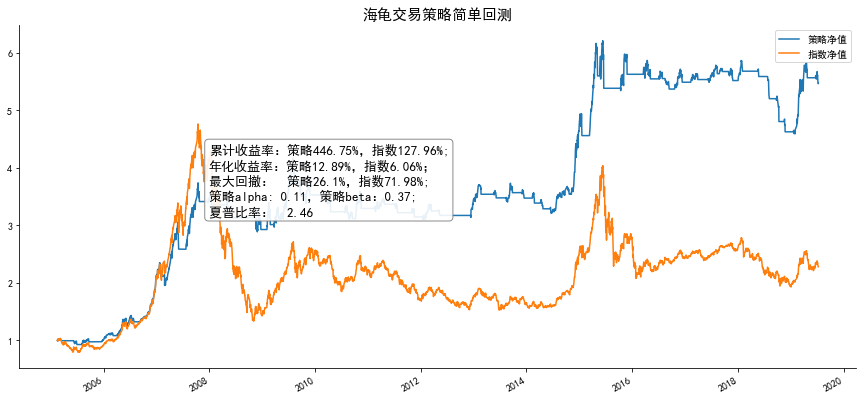

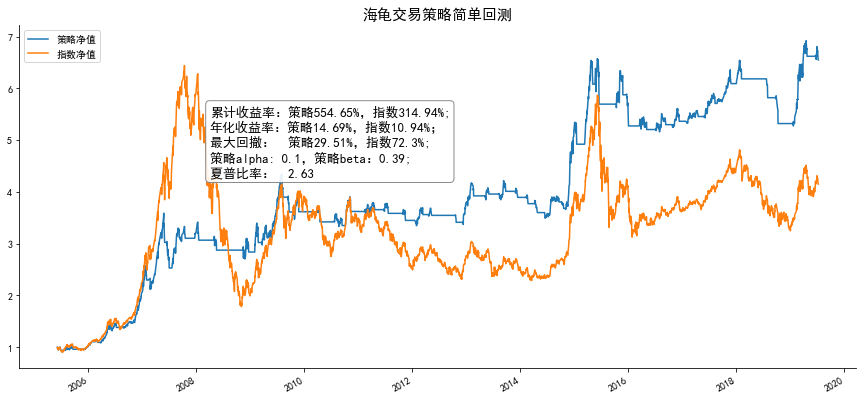

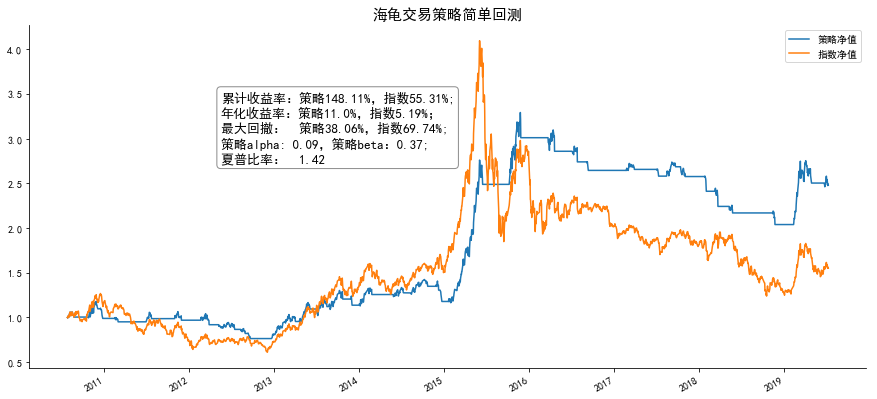

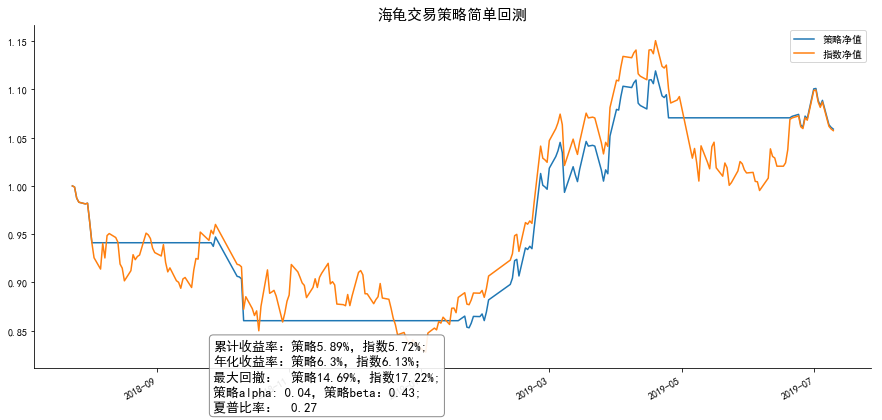

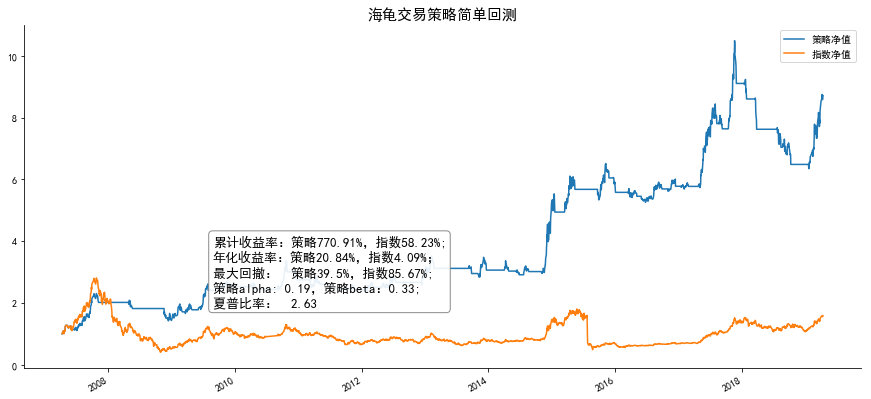

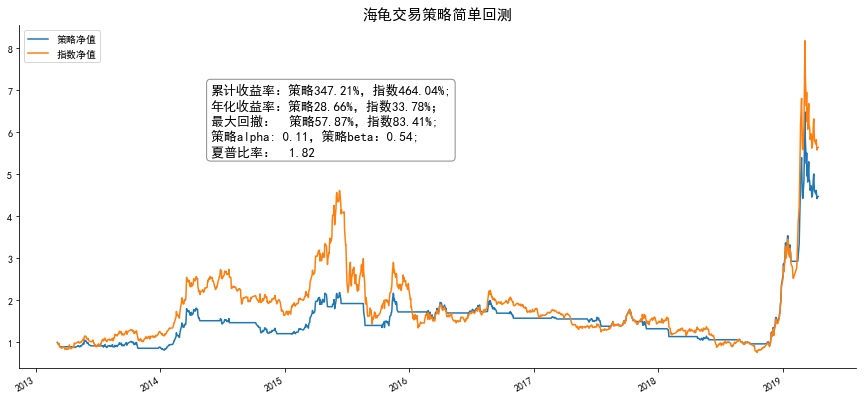

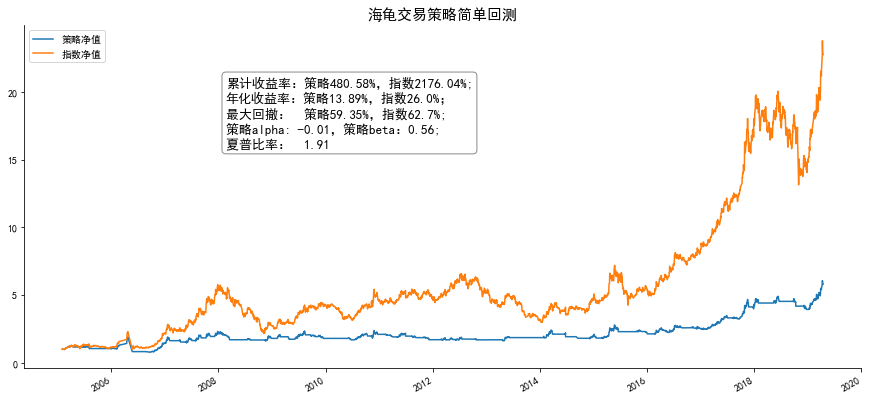

In [75]:
strategy('上证综指','20050101','')
strategy('沪深300','','')
strategy('创业板指','','')
strategy('沪深300','20180101','')
strategy('中国平安','20050101','',N1=20,N2=10)
strategy('东方通信','20130101','',N1=20,N2=10)
strategy('贵州茅台','20050101','',N1=20,N2=10)


上述回测没有考虑使用N值的仓位管理和动态止损，下面是在万矿平台上加入了仓位管理进行回测，与上面简单使用Pandas的回测框架相比（图形比较丑陋），贵州茅台的各项回测指标看上去更理想了，最大回撤也只有21%。具体实现代码可参考万矿平台社区上面的分享。此外，聚宽、优矿等量化平台上也提供了相应了策略回测模板，实现代码大同小异，感兴趣的可以进一步了解。



本文简要介绍了海龟交易法则的基本原理，使用Python对其买卖信号进行了可视化分析，并利用Pandas对相关指数和个股运用简化版的海龟交易规则进行了历史回测。由回测结果可看出，该简化的趋势追踪策略对于某些标的在某些区间效果表现不错，但对于某些标的或某些时期则效果不佳。当然，本文旨在回顾经典策略，展示Pandas在金融量化分析的综合运用，为Python在金融量化中的运用起到抛砖引玉的效果，不作出任何选股或策略推荐。值得注意的是，任何策略都具有一定的局限性，尤其是知道和使用该策略的交易者多了，其作用自然比该理念刚出现的的效果差得多。正如技术分析指标，刚出现的时候很有效，但被大家所熟知或应用后，自然效用就大打折扣（相对于多因子模型中的Alpha被大家挖掘后渐渐成了risk factor）。但所谓新理念、新策略一定是站在前人的肩膀上，因此不能因为经典策略回测效果不佳而全盘否定，如何改进、细化和升级，使之更适合当下的市场才是我们要面对的问题。

